### Parallel Execution

In [47]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class InputState(TypedDict):
    string_value: Annotated[str, operator.add]


In [48]:
def append_a(state: InputState) -> Any:
    print(f"append_a: Current string_value='{state['string_value']}'")
    state["string_value"] += "a"
    return state

def append_b(state: InputState) -> Any:
    print(f"append_b: Current string_value='{state['string_value']}'")
    state["string_value"] += "b"
    return state

def append_c(state: InputState) -> Any:
    print(f"append_c: Current string_value='{state['string_value']}'")
    state["string_value"] += "c"
    return state

def combine_strings(state: InputState) -> Any:
    combined_string = state['string_value']
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state["string_value"] = final_string
    return state

In [49]:
builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)
builder.add_node("append_a_node", append_a)
builder.add_node("append_b_node", append_b)
builder.add_node("append_c_node", append_c)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "append_a_node")
builder.add_edge("start_node", "append_b_node")
builder.add_edge("start_node", "append_c_node")

builder.add_edge("append_a_node", "combine_node")
builder.add_edge("append_b_node", "combine_node")
builder.add_edge("append_c_node", "combine_node")

builder.add_edge("combine_node", END)

graph = builder.compile()

initial_state = {"string_value": ""}

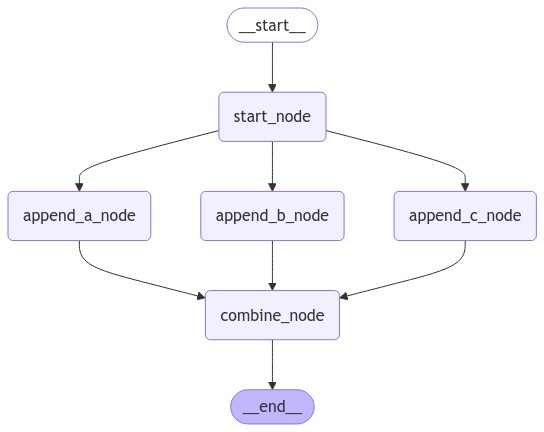

In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
result = graph.invoke(initial_state)
print(result)

append_a: Current string_value=''
append_b: Current string_value=''
append_c: Current string_value=''
combine_strings: Combined string_value='abc'
combine_strings: Final string_value='ABC'
{'string_value': 'abcABC'}


### Be careful! 

In [52]:
import time

class InputState(TypedDict):
    string_value: str
    # string_value: Annotated[str, operator.add]

In [53]:
def change_a(state: InputState) -> InputState:
    print(f"change_a: Current string_value='{state['string_value']}'")
    current_value = state["string_value"]
    time.sleep(0.01)
    state["string_value"] = current_value + "a"
    return state

def combine_strings(state: InputState) -> InputState:
    combined_string = state['string_value']
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state["string_value"] = final_string
    return state


In [54]:
builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)  # Pass-through node
builder.add_node("change_a_node", change_a)
builder.add_node("change_b_node", change_a)
builder.add_node("change_c_node", change_a)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "change_a_node")
builder.add_edge("start_node", "change_b_node")
builder.add_edge("start_node", "change_c_node")

builder.add_edge("change_a_node", "combine_node")
builder.add_edge("change_b_node", "combine_node")
builder.add_edge("change_c_node", "combine_node")

builder.add_edge("combine_node", END)
graph = builder.compile()

In [55]:
initial_state = {"string_value": ""}

result = graph.invoke(initial_state)
print(result)

change_a: Current string_value=''
change_a: Current string_value=''
change_a: Current string_value=''


InvalidUpdateError: At key 'string_value': Can receive only one value per step. Use an Annotated key to handle multiple values.

### Mapreduce with Send API

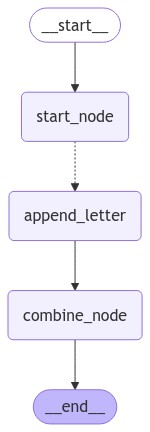

Generating nodes to append letters: ['b', 'a', 'b', 'd']
Appending 'b'
Appending 'a'
Appending 'b'
Appending 'd'
combine_strings: Combined string_value='babd'
combine_strings: Final string_value='BABD'

Final result:
{'string_value': 'babdBABD'}


In [77]:
import operator
import random
from typing import Any, Annotated, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display


class State(TypedDict):
    string_value: Annotated[str, operator.add]

def append_letter(state: State) -> Any:
    letter = state['letter']
    print(f"Appending '{letter}'")
    return {'string_value': letter}

def combine_strings(state: State) -> Any:
    combined_string = state["string_value"]
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    return {'string_value': final_string}

def generate_random_nodes(state: State):
    num_nodes = random.randint(3, 6)
    letters = random.choices(['a', 'b', 'c', 'd', 'e'], k=num_nodes)
    print(f"Generating nodes to append letters: {letters}")
    return [Send("append_letter", {'letter': letter}) for letter in letters]


builder = StateGraph(State)
builder.add_node("start_node", lambda state: state)
builder.add_node("append_letter", append_letter)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")
builder.add_conditional_edges("start_node", generate_random_nodes, ["append_letter"])
builder.add_edge("append_letter", "combine_node")
builder.add_edge("combine_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

initial_state = {"string_value": ""}
result = graph.invoke(initial_state)

print("\nFinal result:")
print(result)
